In [2]:
import torchdata
import torch
from gensim.models import FastText
import pandas as pd
import re
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import spacy
from transformers import AutoModel, AutoTokenizer

from tqdm.auto import tqdm

IGNORE_SAVED_FILES = True
print(torch.__version__, torch.cuda.is_available())
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
vectorizer = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")

1.12.0+cu116 True


In [3]:
with open('./../Data/anek_utf8/anek_utf8.txt', 'r', encoding='utf-8') as f:
    data = f.read()

In [47]:
data_r =  data.replace('<|startoftext|>', '').replace('\\', '').replace('\\\\', '').split('\n\n')

In [48]:
def print_simple_data_pipe(date_pipe: torchdata.datapipes.iter.IterDataPipe, f=lambda a: a, n=10) -> None:
  print(type(date_pipe))
  x = 0
  for sample in date_pipe:
    print(f(sample))
    if x == n:
      break
    x +=1

In [49]:
def bad_patterns_to_tags_replaser2(text: str):
    text = re.sub(r'\d+\:\d+\:\d+', ' <TIME> ', text)
    text = re.sub(r'\d+\:\d+', ' <TIME> ', text)
    text = re.sub(r'\+{,1}\d{1,3}\({,1}[\-\s]{,1}\d{3}\){,1}[\-\s]{,1}\d{3}[\-\s]{,1}\d{2}[\-\s]{,1}\d{2}', ' <PHONE> ', text)
    text = re.sub('\d+/\d+/\d+', ' <DATE> ', text)
    text = re.sub('\d+-\d+-\d+', ' <DATE> ', text)
    text = re.sub('\d+th', ' <ENUM> ', text)
    text = re.sub('\d+rd', ' <ENUM> ', text)
    text = re.sub('\d+st', ' <ENUM> ', text)
    text = re.sub('[\+\-]?\d+.\d+', ' <NUM> ', text)
    text = re.sub('[\+\-]?\d+,\d+', ' <NUM> ', text)
    text = re.sub('\d+', ' <NUM> ', text)
    # text = re.sub(r'\w+\.', '<SHORT>', text[0:-1]) + '.'
    text = re.sub(',', ' , ', text)
    text = re.sub(';', ' ; ', text)
    text = re.sub(';', ' ; ', text)
    text = re.sub('-', ' - ', text)
    text = re.sub(':', ' : ', text)
    text = re.sub('\?', ' \? ', text)
    text = re.sub('"', ' " ', text)
    text = re.sub("'", " ' ", text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub('\.', ' . ', text)
    text = re.sub('\(', ' ( ', text)
    text = re.sub('\)', ' ) ', text)
    text = re.sub('\.  \.  \.', ' ... ', text)
    text = re.sub('\s+', ' ', text)
    return text[0:-1]

In [50]:
tags = ['<SOS>', '<EOS>', '<PAD>', '<UNK>', '<NAN>', '<NUM>', '<TIME>', '<ENUM>', '<DATE>', '<PHONE>', '<EMAIL>', '<SHORT>', '<NAME>']
tags_value = pd.DataFrame({'values': [i / (1+len(tags)) for i in range(1, 1+len(tags))]}, index=tags,)
tags_value.loc['<SOS>', 'values']


0.07142857142857142

In [51]:
data_c =pd.Series(list(map(bad_patterns_to_tags_replaser2, data_r)))

In [52]:
data_c.to_csv('./../Data/anek_utf8/only_text.csv', index=False)

# choose len

In [9]:
lengthes = np.array(list(map(lambda a: len(a.split(' ')), data_c)))


(array([ 7476., 36989., 35532., 21685., 10836.,  5528.,  2474.,   871.,
          219.,    42.]),
 array([ 2., 10., 18., 26., 34., 42., 50., 58., 66., 74., 82.]),
 <BarContainer object of 10 artists>)

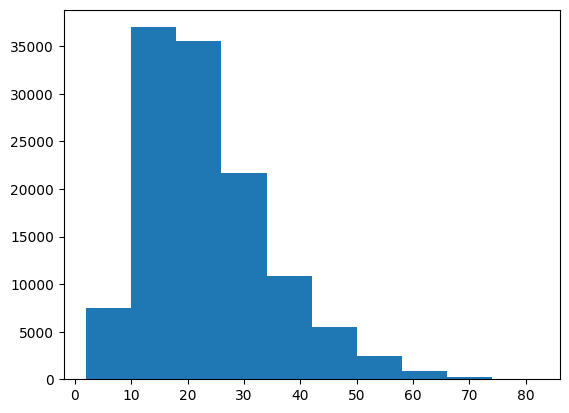

In [10]:
plt.hist(lengthes)

# to torch data

In [64]:
def tokenize(sentence):
    return tokenizer([sentence], padding=True, truncation=True, pad_to_multiple_of=32, max_length=32, return_tensors='pt')

In [68]:
def input_data_check_data_spliter(data):
    with torch.no_grad():
        d_t = tokenize(data[0])
        d_v = vectorizer(**d_t)[0]
    return d_t['input_ids'], d_v, data


In [58]:
output_res = torchdata.datapipes.iter.IterableWrapper(['./../Data/anek_utf8/only_text.csv'])
output_res_pipe = torchdata.datapipes.iter.FileOpener(output_res, mode='r', encoding='utf-8', length=data_c.shape[0])
res_pipe = output_res_pipe.parse_csv(skip_lines=1, delimiter=',')
res_pipe = torchdata.datapipes.map.SequenceWrapper(list(res_pipe))
print_simple_data_pipe(res_pipe, n=3)


<class 'torch.utils.data.datapipes.map.utils.SequenceWrapperMapDataPipe'>
['Сразу после окончания Прямой линии , Путин пожаловался на дефицит интересных и актуальных вопросов , отметив , что критическое положение , слава богу , спасли осмысленные вопросы Шнурова , и очень своевременно поднятый вопрос о ситуации с Дзюбой .']
['Это Аркадий . Аркадий попал в армию через постель . Он проспал госэкзамены .']
['Толкучка в атобусе . Автобус резко тормозит и женщина падает на рядом седящего свещеника , восклицает : " Ого! " . На что свещеник отвечает : " Не ого , а ключ от храма " .']
['Интересно , гадалка уже догадалась , что я еду к ней в Чертаново бухая в очко \\?']


In [78]:
ready = res_pipe.map(input_data_check_data_spliter)
print_simple_data_pipe(ready, n=3, f=lambda a: (a[0].shape, a[1].shape, a[2]))

<class 'torch.utils.data.datapipes.map.callable.MapperMapDataPipe'>
(torch.Size([1, 32]), torch.Size([1, 32, 1024]), ['Сразу после окончания Прямой линии , Путин пожаловался на дефицит интересных и актуальных вопросов , отметив , что критическое положение , слава богу , спасли осмысленные вопросы Шнурова , и очень своевременно поднятый вопрос о ситуации с Дзюбой .'])
(torch.Size([1, 32]), torch.Size([1, 32, 1024]), ['Это Аркадий . Аркадий попал в армию через постель . Он проспал госэкзамены .'])
(torch.Size([1, 32]), torch.Size([1, 32, 1024]), ['Толкучка в атобусе . Автобус резко тормозит и женщина падает на рядом седящего свещеника , восклицает : " Ого! " . На что свещеник отвечает : " Не ого , а ключ от храма " .'])
(torch.Size([1, 32]), torch.Size([1, 32, 1024]), ['Интересно , гадалка уже догадалась , что я еду к ней в Чертаново бухая в очко \\?'])


In [79]:
def join(batch):
    d1, d2, d3 = [], [], []
    for i, j, k in batch:
        d1.append(i)
        d2.append(j)
        d3.append(k)
    return torch.concat(d1), torch.concat(d2), d3

In [80]:
res = torchdata.datapipes.map.Batcher(torchdata.datapipes.map.Shuffler(ready), batch_size=32)

# Make model

In [81]:
device = 'cuda'

In [253]:
class Attention(torch.nn.Module):
    def __init__(self, emb_size, n_heads):
        super(Attention, self).__init__()
        self.n_heads = n_heads
        self.wQ = (torch.nn.parameter.Parameter(torch.rand([n_heads, emb_size, emb_size])).to(device))
        self.wK = torch.nn.parameter.Parameter(torch.rand([n_heads, emb_size, emb_size])).to(device)
        self.wV = torch.nn.parameter.Parameter(torch.rand([n_heads, emb_size, emb_size])).to(device)
        self.wO = torch.nn.parameter.Parameter(torch.rand([n_heads * emb_size, emb_size])).to(device)

    def forward(self, en_out):
        eo = en_out.clone()
        for i in range(eo.shape[0]):
            m = eo[i].unsqueeze(0)
            eo[i] = self.iteration(m, m, m)
        return eo

    def iteration(self, Q: torch.tensor, K: torch.tensor, V: torch.tensor):
        d = Q.shape[2]
        s = Q.shape[1]
        qp = Q.repeat(self.n_heads, 1, 1).bmm(self.wQ)
        kp = K.repeat(self.n_heads, 1, 1).bmm(self.wK)
        vp = V.repeat(self.n_heads, 1, 1).bmm(self.wV)
        res = torch.softmax(qp.bmm(kp.transpose(1, 2))/d**0.5, 1)
        res2 = (res.bmm(vp))
        return res2.view(s, d * self.n_heads).mm(self.wO)

att = Attention(128, 4).to(device)

In [86]:
class Decoder(torch.nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size):
    super(Decoder, self).__init__()
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size
    self.tag = True
    self.embedding = torch.nn.Embedding(self.input_size, self.embedding_size)
    self.GRU = torch.nn.GRU(self.embedding_size, hidden_size, num_layers)
    self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

  def forward(self, x, hidden_state):
    x = x.unsqueeze(0)
    embedding = self.embedding(x)
    outputs, hidden_state = self.GRU(embedding, hidden_state)
    predictions = self.fc(outputs)
    predictions = predictions.squeeze(0)
    return predictions, hidden_state

input_size_decoder = 120138
decoder_embedding_size = 256
hidden_size = 1024
num_layers = 2
output_size = 120138

decoder_gru = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, num_layers, output_size).to(device)
print(decoder_gru)

Decoder(
  (embedding): Embedding(120138, 256)
  (GRU): GRU(256, 1024, num_layers=2)
  (fc): Linear(in_features=1024, out_features=120138, bias=True)
)


In [ ]:
class Seq2Seq(torch.nn.Module):
  def __init__(
    self, 
    input_vocab_size,
    output_vocab_size,
    decoder_embedding_size,
    position_coording_matrix,
    Decoder, 
    # Attention
  ):
    super(Seq2Seq, self).__init__()
    self.input_vocab_size = input_vocab_size
    self.output_vocab_size = output_vocab_size
    self.encoder_embedding_size = encoder_embedding_size
    self.decoder_embedding_size = decoder_embedding_size
    self.position_coording_matrix = position_coording_matrix
    self.encoder_embeder = torch.nn.Embedding(self.input_vocab_size, self.encoder_embedding_size)
    self.decoder_embeder = torch.nn.Embedding(self.output_vocab_size, self.decoder_embedding_size)
    self.Decoder = Decoder
    # self.attention = Attention

  def forward(self, source, target, tfr=0.2):
    source = source.transpose(0, 1)
    target = target.transpose(0, 1)
    batch_size = source.shape[1]
    target_len = target.shape[0]
    target_vocab_size = self.output_vocab_size
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
    hidden_state_encoder = source
    x = target[0,:]
    for i in range(1, target_len):
      inDec = self.decoder_embeder(x.unsqueeze(0))
      output, _ = self.Decoder(inDec, hidden_state_encoder)
      outputs[i] = output
      best_guess = output.argmax(1)
      x = target[i] if np.random.random() < tfr else best_guess
    return outputs.transpose(0, 1)


input_size_decoder = 120138
encoder_embedding_size = 128
decoder_embedding_size = 128
model = Seq2Seq().to(device)


# Tests

In [84]:
for batch in res:
    y_b, x_b, t_b = join(batch)
    break
y_b.shape, x_b.shape, t_b 

(torch.Size([32, 32]),
 torch.Size([32, 32, 1024]),
 [['Денег - как кот наплакал , а проблем - как слон насрал .'],
  [' - Какое красивое у вас платье . Вы , наверное , выпускница \\? - Да . Как вы догадались \\? - Ну вы просто наблевали рядом и лежите тут на скамейке .'],
  [' - Простите , вы своими проблемами не поделитесь \\? Просто вы так аппетитно депрессуете , что мне тоже захотелось .'],
  ['Журналист задает вопрос известному художнику : - Самое радостное событие для художника - это первая выставка его картин \\? - Нет , пожалуй , самое радостное событие - это когда у него впервые украдут какую - нибудь картину .'],
  ['Выкурил каплю никотина - спас лошадь'],
  [' - Доктор , окружающие говорят , что я чрезмерно cекcуально озабочен . - Ну те - с , проверим . Что вы видите , - рисует прямоугольник , - на этом рисунке \\? - Ну что же еще \\? Это - темная комната , в углу кровать , а на ней - любовная пара . - Хм , допустим . А здесь \\?'],
  ['Жена говорит мужу : - Ты почему , при 